In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from shapely.geometry import Polygon, Point 
import folium.colormap as cm

In [2]:
crime_chicago = pd.read_pickle('crime_chicago_with_better_timestamp.pkl')

#### Binning

We have decided to use 50 bins as this number offers a good resolution and can be computed in a reasonable time. The bins are based on gps coordinates.

In [3]:
number_of_bins = 50
no = number_of_bins

lat_min = crime_chicago['Latitude'].min()
lon_min = crime_chicago['Longitude'].min()

lat_span = crime_chicago['Latitude'].max() - crime_chicago['Latitude'].min()
lon_span = crime_chicago['Longitude'].max() - crime_chicago['Longitude'].min()

lat_step = lat_span / no
lon_step = lon_span / no

In [4]:
crime_chicago['bin'] = \
    no*np.floor((crime_chicago['Longitude']-lon_min)/lon_step) + \
       np.floor((crime_chicago['Latitude'] -lat_min)/lat_step)

In [5]:
def getCornerLatLonForBin(bin_no):
    return (
        lat_min + (bin_no % no)         *lat_step, 
        lon_min + np.floor(bin_no / no) *lon_step
    )

In [6]:
def getPolygonForBin(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lat,            lon),
            (lat,            lon + lon_step),
            (lat + lat_step, lon + lon_step),
            (lat + lat_step, lon),
        ])

In [7]:
def getPolygonForBinReverse(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lon,            lat),
            (lon + lon_step, lat),
            (lon + lon_step, lat + lat_step),
            (lon,            lat + lat_step),
        ])

#### Grouping

In [8]:
crime_chicago_count = crime_chicago[['bin']].groupby(['bin']).size().reset_index().rename(columns={0:'count'})

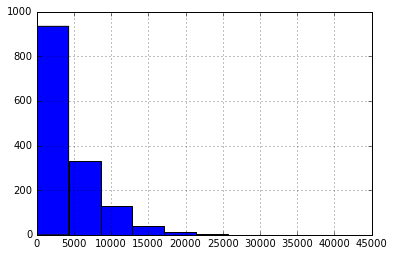

In [10]:
crime_chicago_count['count'].hist()

#### Transforming to GeoDataFrame

In [54]:
crime_chicago_count_gpd = None

In [55]:
crime_chicago_count_gpd = gpd.GeoDataFrame(crime_chicago_count)

In [56]:
crime_chicago_count_gpd.geometry = crime_chicago_count_gpd['bin'] \
    .map(lambda x: getPolygonForBinReverse(x))

In [57]:
max_count = crime_chicago_count_gpd['count'].max()
crime_chicago_count_gpd['relative_count'] = crime_chicago_count_gpd['count']/max_count

In [58]:
linear = cm.LinearColormap(['green','yellow','red'])
linear

In [59]:
scl = cm.LinearColormap(['green','yellow','red']).to_step(n=100, method='log')

In [60]:
crime_chicago_count_gpd['style'] = crime_chicago_count_gpd['relative_count'] \
    .map(lambda x: {'fillColor' : scl(x), 'weight' : 0})

In [61]:
crime_chicago_count_gpd.head(1)

,bin,count,geometry,relative_count,style
0,38,59,"POLYGON ((-87.82109968499999 41.92875509388, -...",0.001376,"{'fillColor': '#008000', 'weight': 0}"


In [62]:
crime_chicago_count_gpd.crs = {'init': 'epsg:4326', 'no_defs': True}

In [63]:
m = folium.Map([41.80,-87.75], zoom_start=11, tiles='cartodbpositron')

folium.GeoJson(crime_chicago_count_gpd).add_to(m)

May be useful later

In [64]:
# m = folium.Map([41.80,-87.75], zoom_start=11, tiles='cartodbpositron')

# folium.GeoJson(
#     crime_chicago_count_gpd,
#     style_function=lambda feature: {
#         'fillColor': linear(crime_chicago_count_gpd[]),
#         'color' : 'black',
#         'weight' : 2,
#         'dashArray' : '5, 5'
#         }).add_to(m)

# m

In this part we add some shopping centres (17) to the map - using the gps coordinates. These shopping centres are some of the biggest ones in Chicago, and it is quite interesting to see how much criminal activity is near the individual shopping centres. In some of them it is more, in some less, but it still gives an interesting insight for the businesses.

In [65]:
m.add_children(folium.Marker([41.868648, -87.640007], popup="The Maxwell", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.897754, -87.623944], popup="Water Tower Place", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.899274, -87.624524], popup="900 North Michigan Shops", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.929220, -87.787405], popup="Brickyard Mall", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.891145, -87.624482], popup="The Shops at North Bridge", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.939177, -87.649695], popup="Pointe At Clark", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.926000, -87.673170], popup="Riverpoint Center", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.755380, -87.736369], popup="Ford City Mall", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.832392, -87.615014], popup="Lake Meadows Shopping Center", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.908722, -87.748696], popup="Washington Square Mall", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.991941, -87.655026], popup="Captains Walk Shopping Mall", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.932977, -87.648383], popup="Diversey Halsted Shopping Center", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.925253, -87.789883], popup="Bricktown Square", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.910541, -87.635704], popup="Pipers Alley Mall", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.890795, -87.616483], popup="Ogden Slip", icon=folium.Icon(color='gray')))

m.add_children(folium.Marker([41.883819, -87.627683], popup="Tiffany Dome", icon=folium.Icon(color='gray')))
m.add_children(folium.Marker([41.883533, -87.629430], popup="Block 37", icon=folium.Icon(color='gray')))

Here we just save the map into a html file as we want to use it in our web app.

In [ ]:
m.save('map_with_markers.html')